ede2110 emile esmaili


Notebook pipeline: 

- Subtype classification with L1-Logit
- Feature importance with SHAP
- Most important genes embedded with BERT
- embeddings dim reduced
- Clustering of reduced embeddings

# TODO

- get table with longer descriptions
- use leiden clustering or other and not kmeans



# Imports

In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import shap 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns

from sklearn.preprocessing import StandardScaler

sc.settings.verbosity = 3 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

In [2]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")
raw_data_rna.head(3)

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,...,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197
1,NaN,100133144,0.1185,2.0342,0.5116,0.1034,-3.1094,-0.4877,-0.8870,0.0577,...,1.1529,0.5938,0.4161,-0.0182,-1.0264,-0.4623,0.0507,0.4778,-0.4763,0.2876
2,UBE2Q2P2,100134869,0.8030,0.6853,-0.3650,-1.5341,1.2744,1.1389,-0.7295,0.1724,...,0.7471,1.0861,0.0440,0.2981,-0.4821,0.2481,0.5676,0.4846,-0.6968,-0.9707


In [3]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose().dropna(axis=1)
df_clean.head()

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,-6.6197,0.1185,0.8030,1.9096,1.1627,-1.2910,-1.1661,-24.2671,-0.8905,-0.7464,...,-1.0345,-1.3155,-0.0235,0.7347,0.2169,-1.2143,0.4502,-0.8102,-1.2280,1.0099
TCGA-CS-4941-01,-6.6197,2.0342,0.6853,0.2687,-1.7875,-0.3693,0.5989,-24.2671,-0.2931,-0.8891,...,0.5681,-0.3297,0.9896,0.3312,-0.0860,-0.7410,0.9028,0.9552,0.1514,1.5061
TCGA-CS-4942-01,-6.6197,0.5116,-0.3650,0.7763,-0.0135,-1.8175,-2.1143,-24.2671,-1.0988,-0.8873,...,-0.2736,0.3326,1.1601,0.2281,-0.5701,-0.7399,0.6187,-0.1635,-0.5145,0.5814
TCGA-CS-4943-01,-6.6197,0.1034,-1.5341,1.9239,1.1169,-2.5350,-1.3505,-24.2671,-1.3783,-1.6739,...,2.9808,2.6781,0.6371,0.5073,0.1360,1.0996,0.9174,-0.2393,0.5748,0.5170
TCGA-CS-4944-01,-6.6197,-3.1094,1.2744,1.2506,1.0094,-2.5886,-2.1143,-24.2671,-0.4584,-1.6739,...,-1.6638,-1.1717,-0.8581,-0.9870,-0.9546,-0.5623,-0.1225,-0.6971,-2.9617,-0.5319


## Preprocess pipeline - Genomics + Clinical

In [4]:

## read patient data and preprocessing...

# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()



raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

df_sample_with_gene = df_clean.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

df_drop = df.drop(df[df.Subtype.isnull()].index, axis = 0)

# assign features, target and encoding...
y = df_drop["Subtype"]
X= df_drop.drop("Subtype", axis = 1)

y = y.map({"LGG_IDHmut-non-codel":0, "LGG_IDHwt":1, "LGG_IDHmut-codel":2})


X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

If there is NA values: False


## Import gene decription

In [5]:
df_gene_reference = pd.read_table("./supplement_data/gene_table.tsv")
df_gene_reference.head()
#df_gene_description = df_clean.merge(df_gene_reference, how = "left", left_on = "Entrez_Gene_Id", right_on = "NCBI GeneID")

# here is the table with the description:
#df_important_gene_description.head(10)

,NCBI GeneID,Symbol,Description,Taxonomic Name,Gene Type,Gene Group Identifier,Gene Group Method
0,7157,TP53,tumor protein p53,Homo sapiens,PROTEIN_CODING,7157.0,NCBI Ortholog
1,1956,EGFR,epidermal growth factor receptor,Homo sapiens,PROTEIN_CODING,1956.0,NCBI Ortholog
2,7124,TNF,tumor necrosis factor,Homo sapiens,PROTEIN_CODING,7124.0,NCBI Ortholog
3,348,APOE,apolipoprotein E,Homo sapiens,PROTEIN_CODING,348.0,NCBI Ortholog
4,7422,VEGFA,vascular endothelial growth factor A,Homo sapiens,PROTEIN_CODING,7422.0,NCBI Ortholog


# Run a simple classification model, get most important genes

In [6]:
clf = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
clf.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')

In [7]:
# get the model coefficients
coefficients = clf.coef_
intercept = clf.intercept_

y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

print("Train score", clf.score(X_train, y_train), "\nTest Score", clf.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.90      0.95        21
           2       1.00      1.00      1.00        42

    accuracy                           0.98       127
   macro avg       0.99      0.97      0.98       127
weighted avg       0.98      0.98      0.98       127

Train score 1.0 
Test Score 0.984251968503937


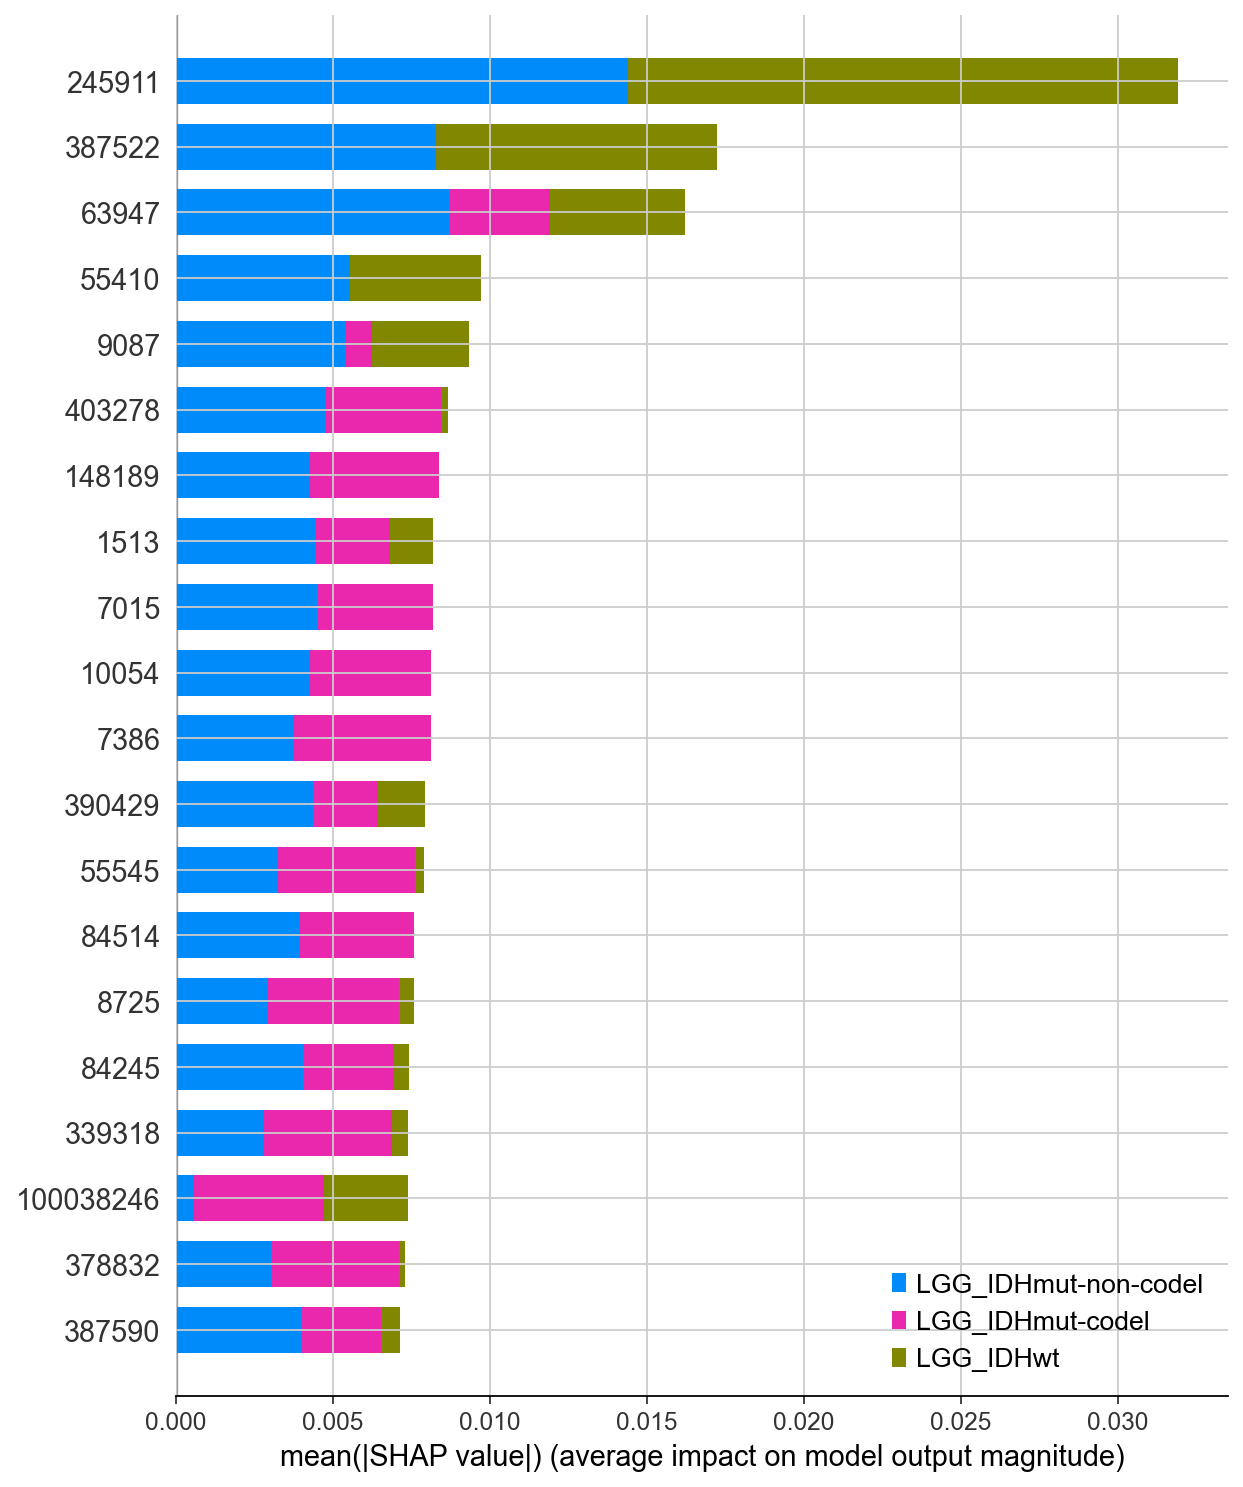

In [8]:
explainer = shap.Explainer(clf, X_train, feature_names=X.columns)
shap_values = explainer.shap_values(X_test)

# get the table for feature_importance
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance.reset_index(drop=True)

# the plot for the data
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_values, X_train.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

In [9]:
top_n = 100
most_important_genes = pd.merge(feature_importance,df_gene_reference,
                                left_on='gene_id',
                                  right_on='NCBI GeneID').drop(['Taxonomic Name',
                                                                'Gene Group Identifier',
                                                                'Gene Group Method',
                                                                'NCBI GeneID'],
                                                                axis=1
                                                                )
n_most_important_genes = most_important_genes.nlargest(top_n, columns=['feature_importance_vals'])
n_most_important_genes.head(10)

,gene_id,feature_importance_vals,Symbol,Description,Gene Type
0,245911,1.350325,DEFB108B,defensin beta 108B,PROTEIN_CODING
1,387522,0.728675,PEDS1-UBE2V1,PEDS1-UBE2V1 readthrough,PROTEIN_CODING
2,63947,0.686679,DMRTC1,DMRT like family C1,PROTEIN_CODING
3,9087,0.394466,TMSB4Y,thymosin beta 4 Y-linked,PROTEIN_CODING
4,403278,0.365980,OR5K4,olfactory receptor family 5 subfamily K member 4,PROTEIN_CODING
5,148189,0.354748,LINC00662,long intergenic non-protein coding RNA 662,ncRNA
6,1513,0.345865,CTSK,cathepsin K,PROTEIN_CODING
7,7015,0.345715,TERT,telomerase reverse transcriptase,PROTEIN_CODING
8,10054,0.343736,UBA2,ubiquitin like modifier activating enzyme 2,PROTEIN_CODING
9,7386,0.343199,UQCRFS1,"ubiquinol-cytochrome c reductase, Rieske iron-...",PROTEIN_CODING


# pretrained BERT, encode descriptions

In [10]:
model = SentenceTransformer('emilyalsentzer/Bio_ClinicalBERT')

No sentence-transformers model found with name C:\Users\emile/.cache\torch\sentence_transformers\emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\emile/.cache\torch\sentence_transformers\emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

In [11]:
descriptions = n_most_important_genes['Description']
embeddings = model.encode(descriptions)

In [12]:
embeddings.shape

(100, 768)

# Reduce dim of embeddings then cluster

In [13]:
# Standardize the dataset X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

# Perform PCA on the standardized dataset X
pca = PCA(n_components=50)
pca.fit(X_scaled)


# Obtain the principal components and the explained variance ratios
principal_components = pca.transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
print('explained variance is',explained_variance.sum())

# Create a new DataFrame with the principal components and the "cluster" column
df_pca = pd.DataFrame(data = principal_components)

explained variance is 0.8955034


In [14]:
tsne = TSNE()
embed = tsne.fit_transform(X_scaled)
# Create a new DataFrame with the principal components and the "cluster" column
df_embed = pd.DataFrame(data = embed, columns=['dim1','dim2'])

In [15]:
umapp = umap.UMAP()
embed = umapp.fit_transform(X_scaled)
df_embed = pd.DataFrame(data = embed, columns=['dim1','dim2'])

In [16]:

wcss_pca = []
wcss_umap = []
n_test = 20
# Perform k-means clustering for each k value from 1 to 10
for k in range(1, n_test):
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(df_pca)
    kmeans_umap = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(embed)
    wcss_pca.append(kmeans_pca.inertia_)
    wcss_umap.append(kmeans_umap.inertia_)

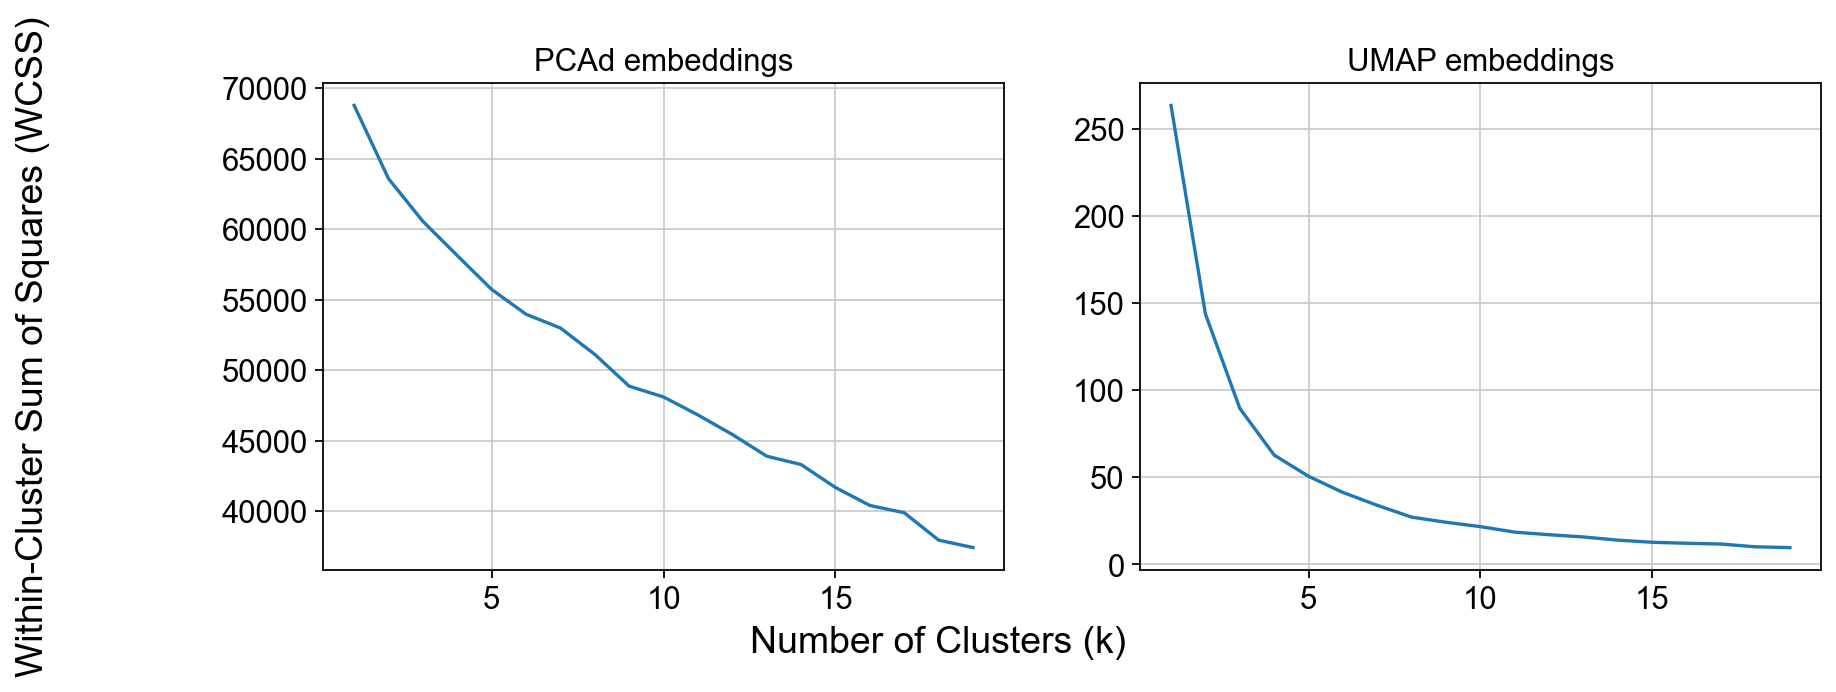

In [17]:
# Create a scree plot
fig, ax = plt.subplots(1,2,sharex=True, figsize=(12,4))
ax[0].plot(range(1, n_test), wcss_pca)
ax[1].plot(range(1, n_test), wcss_umap)
ax[0].set_title('PCAd embeddings')
ax[1].set_title('UMAP embeddings')
fig.supxlabel('Number of Clusters (k)')
fig.supylabel('Within-Cluster Sum of Squares (WCSS)')
#fig.suptitle('Scree Plot with embeddings')
plt.show()

# cluster

In [18]:
n_clusters = 8
X = X_scaled
kmeans = KMeans(n_clusters=n_clusters).fit(X)
labels = pd.DataFrame(kmeans.labels_, columns=['cluster'])

In [19]:
clusters_df = pd.concat([n_most_important_genes, df_embed, labels],axis=1)
clusters_df.groupby(by='cluster').count().iloc[:,0]


cluster
0     9
1    13
2    13
3     4
4    30
5    23
6     4
7     4
Name: gene_id, dtype: int64

## Looking at description

In [20]:

clusters_df[clusters_df['cluster']==0]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
22,653567,0.289997,TMEM236,transmembrane protein 236,PROTEIN_CODING,-7.607896,5.638669,0
24,56181,0.285804,MTFR1L,mitochondrial fission regulator 1 like,PROTEIN_CODING,-7.654279,5.104752,0
25,54455,0.285167,FBXO42,F-box protein 42,PROTEIN_CODING,-8.646464,4.500422,0
44,11264,0.263131,PXMP4,peroxisomal membrane protein 4,PROTEIN_CODING,-7.845607,6.056864,0
50,84902,0.257604,CEP89,centrosomal protein 89,PROTEIN_CODING,-7.407655,5.729890,0
72,83636,0.246014,C19orf12,chromosome 19 open reading frame 12,PROTEIN_CODING,-5.606660,3.495342,0
77,10775,0.241117,POP4,"POP4 homolog, ribonuclease P/MRP subunit",PROTEIN_CODING,-7.070242,5.121080,0
81,10946,0.239910,SF3A3,splicing factor 3a subunit 3,PROTEIN_CODING,-7.810467,5.520213,0
83,9554,0.238719,SEC22B,"SEC22 homolog B, vesicle trafficking protein",PROTEIN_CODING,-7.269855,4.923755,0


In [21]:
clusters_df[clusters_df['cluster']==1]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
1,387522,0.728675,PEDS1-UBE2V1,PEDS1-UBE2V1 readthrough,PROTEIN_CODING,-5.144048,4.596294,1
16,100038246,0.312335,TLX1NB,TLX1 neighbor,ncRNA,-5.198816,4.654891,1
26,3209,0.284383,HOXA13,homeobox A13,PROTEIN_CODING,-4.840211,5.296139,1
27,390790,0.283192,ARL5C,ADP ribosylation factor like GTPase 5C,PROTEIN_CODING,-5.642024,5.088462,1
33,64211,0.279282,LHX5,LIM homeobox 5,PROTEIN_CODING,-4.665132,5.670479,1
34,134266,0.279000,GRPEL2,"GrpE like 2, mitochondrial",PROTEIN_CODING,-6.203562,4.879568,1
38,79192,0.268698,IRX1,iroquois homeobox 1,PROTEIN_CODING,-5.343902,5.328503,1
63,79084,0.250336,WDR77,WD repeat domain 77,PROTEIN_CODING,-5.689736,4.930192,1
68,28954,0.248859,REM1,RRAD and GEM like GTPase 1,PROTEIN_CODING,-5.995945,5.150487,1
74,4774,0.242775,NFIA,nuclear factor I A,PROTEIN_CODING,-6.068941,5.498616,1


In [22]:
clusters_df[clusters_df['cluster']==2]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
5,148189,0.354748,LINC00662,long intergenic non-protein coding RNA 662,ncRNA,-5.513458,3.902922,2
11,55545,0.334495,MSX2P1,msh homeobox 2 pseudogene 1,PSEUDO,-6.188543,3.382708,2
13,8725,0.320201,URI1,URI1 prefoldin like chaperone,PROTEIN_CODING,-6.096895,4.508367,2
17,378832,0.308579,COL18A1-AS1,COL18A1 antisense RNA 1,ncRNA,-6.478312,4.333703,2
18,387590,0.302425,TPTEP1,TPTE pseudogene 1,PSEUDO,-5.729535,3.519492,2
20,55695,0.293306,NSUN5,NOP2/Sun RNA methyltransferase 5,PROTEIN_CODING,-6.588164,4.781012,2
30,93010,0.280976,B3GNT7,"UDP-GlcNAc:betaGal beta-1,3-N-acetylglucosamin...",PROTEIN_CODING,-6.855589,6.755857,2
35,26065,0.274769,LSM14A,LSM14A mRNA processing body assembly factor,PROTEIN_CODING,-5.770761,4.482298,2
39,79730,0.268220,NSUN7,NOP2/Sun RNA methyltransferase family member 7,PROTEIN_CODING,-6.560068,4.137458,2
53,80341,0.253113,BPIFB2,BPI fold containing family B member 2,PROTEIN_CODING,-6.293383,4.213414,2


In [23]:
clusters_df[clusters_df['cluster']==3]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
15,339318,0.313028,ZNF181,zinc finger protein 181,PROTEIN_CODING,-9.205673,4.149487,3
28,55900,0.282930,ZNF302,zinc finger protein 302,PROTEIN_CODING,-9.305379,4.123448,3
73,22847,0.243292,ZNF507,zinc finger protein 507,PROTEIN_CODING,-9.470736,3.889040,3
87,80032,0.236868,ZNF556,zinc finger protein 556,PROTEIN_CODING,-9.322189,4.001506,3


In [24]:
clusters_df[clusters_df['cluster']==4]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
0,245911,1.350325,DEFB108B,defensin beta 108B,PROTEIN_CODING,-5.231446,6.295008,4
3,9087,0.394466,TMSB4Y,thymosin beta 4 Y-linked,PROTEIN_CODING,-5.698680,5.734563,4
6,1513,0.345865,CTSK,cathepsin K,PROTEIN_CODING,-5.082948,6.559050,4
7,7015,0.345715,TERT,telomerase reverse transcriptase,PROTEIN_CODING,-6.026668,6.598145,4
8,10054,0.343736,UBA2,ubiquitin like modifier activating enzyme 2,PROTEIN_CODING,-6.609730,5.433506,4
9,7386,0.343199,UQCRFS1,"ubiquinol-cytochrome c reductase, Rieske iron-...",PROTEIN_CODING,-7.688997,6.479695,4
14,84245,0.314457,MRI1,methylthioribose-1-phosphate isomerase 1,PROTEIN_CODING,-7.492047,7.311584,4
19,7268,0.297201,TTC4,tetratricopeptide repeat domain 4,PROTEIN_CODING,-6.238672,6.852990,4
29,149175,0.281402,MANEAL,mannosidase endo-alpha like,PROTEIN_CODING,-6.625411,6.117148,4
36,10352,0.274085,WARS2,"tryptophanyl tRNA synthetase 2, mitochondrial",PROTEIN_CODING,-6.712494,7.187239,4


In [25]:
clusters_df[clusters_df['cluster']==5]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
4,403278,0.365980,OR5K4,olfactory receptor family 5 subfamily K member 4,PROTEIN_CODING,-6.897213,3.647361,5
10,390429,0.335813,OR4N2,olfactory receptor family 4 subfamily N member 2,PROTEIN_CODING,-6.777306,3.672208,5
12,84514,0.320378,GHDC,GH3 domain containing,PROTEIN_CODING,-7.740612,4.925072,5
23,54101,0.289734,RIPK4,receptor interacting serine/threonine kinase 4,PROTEIN_CODING,-7.252438,6.891594,5
31,55108,0.280881,BSDC1,BSD domain containing 1,PROTEIN_CODING,-7.856633,5.015576,5
32,3195,0.280297,TLX1,T cell leukemia homeobox 1,PROTEIN_CODING,-7.346699,4.229148,5
43,84306,0.265726,PDCD2L,programmed cell death 2 like,PROTEIN_CODING,-7.731406,4.543674,5
45,84079,0.262522,ANKRD27,ankyrin repeat domain 27,PROTEIN_CODING,-8.724931,5.555941,5
46,4802,0.261910,NFYC,nuclear transcription factor Y subunit gamma,PROTEIN_CODING,-8.813316,6.048382,5
49,6910,0.257665,TBX5,T-box transcription factor 5,PROTEIN_CODING,-8.854083,5.962728,5


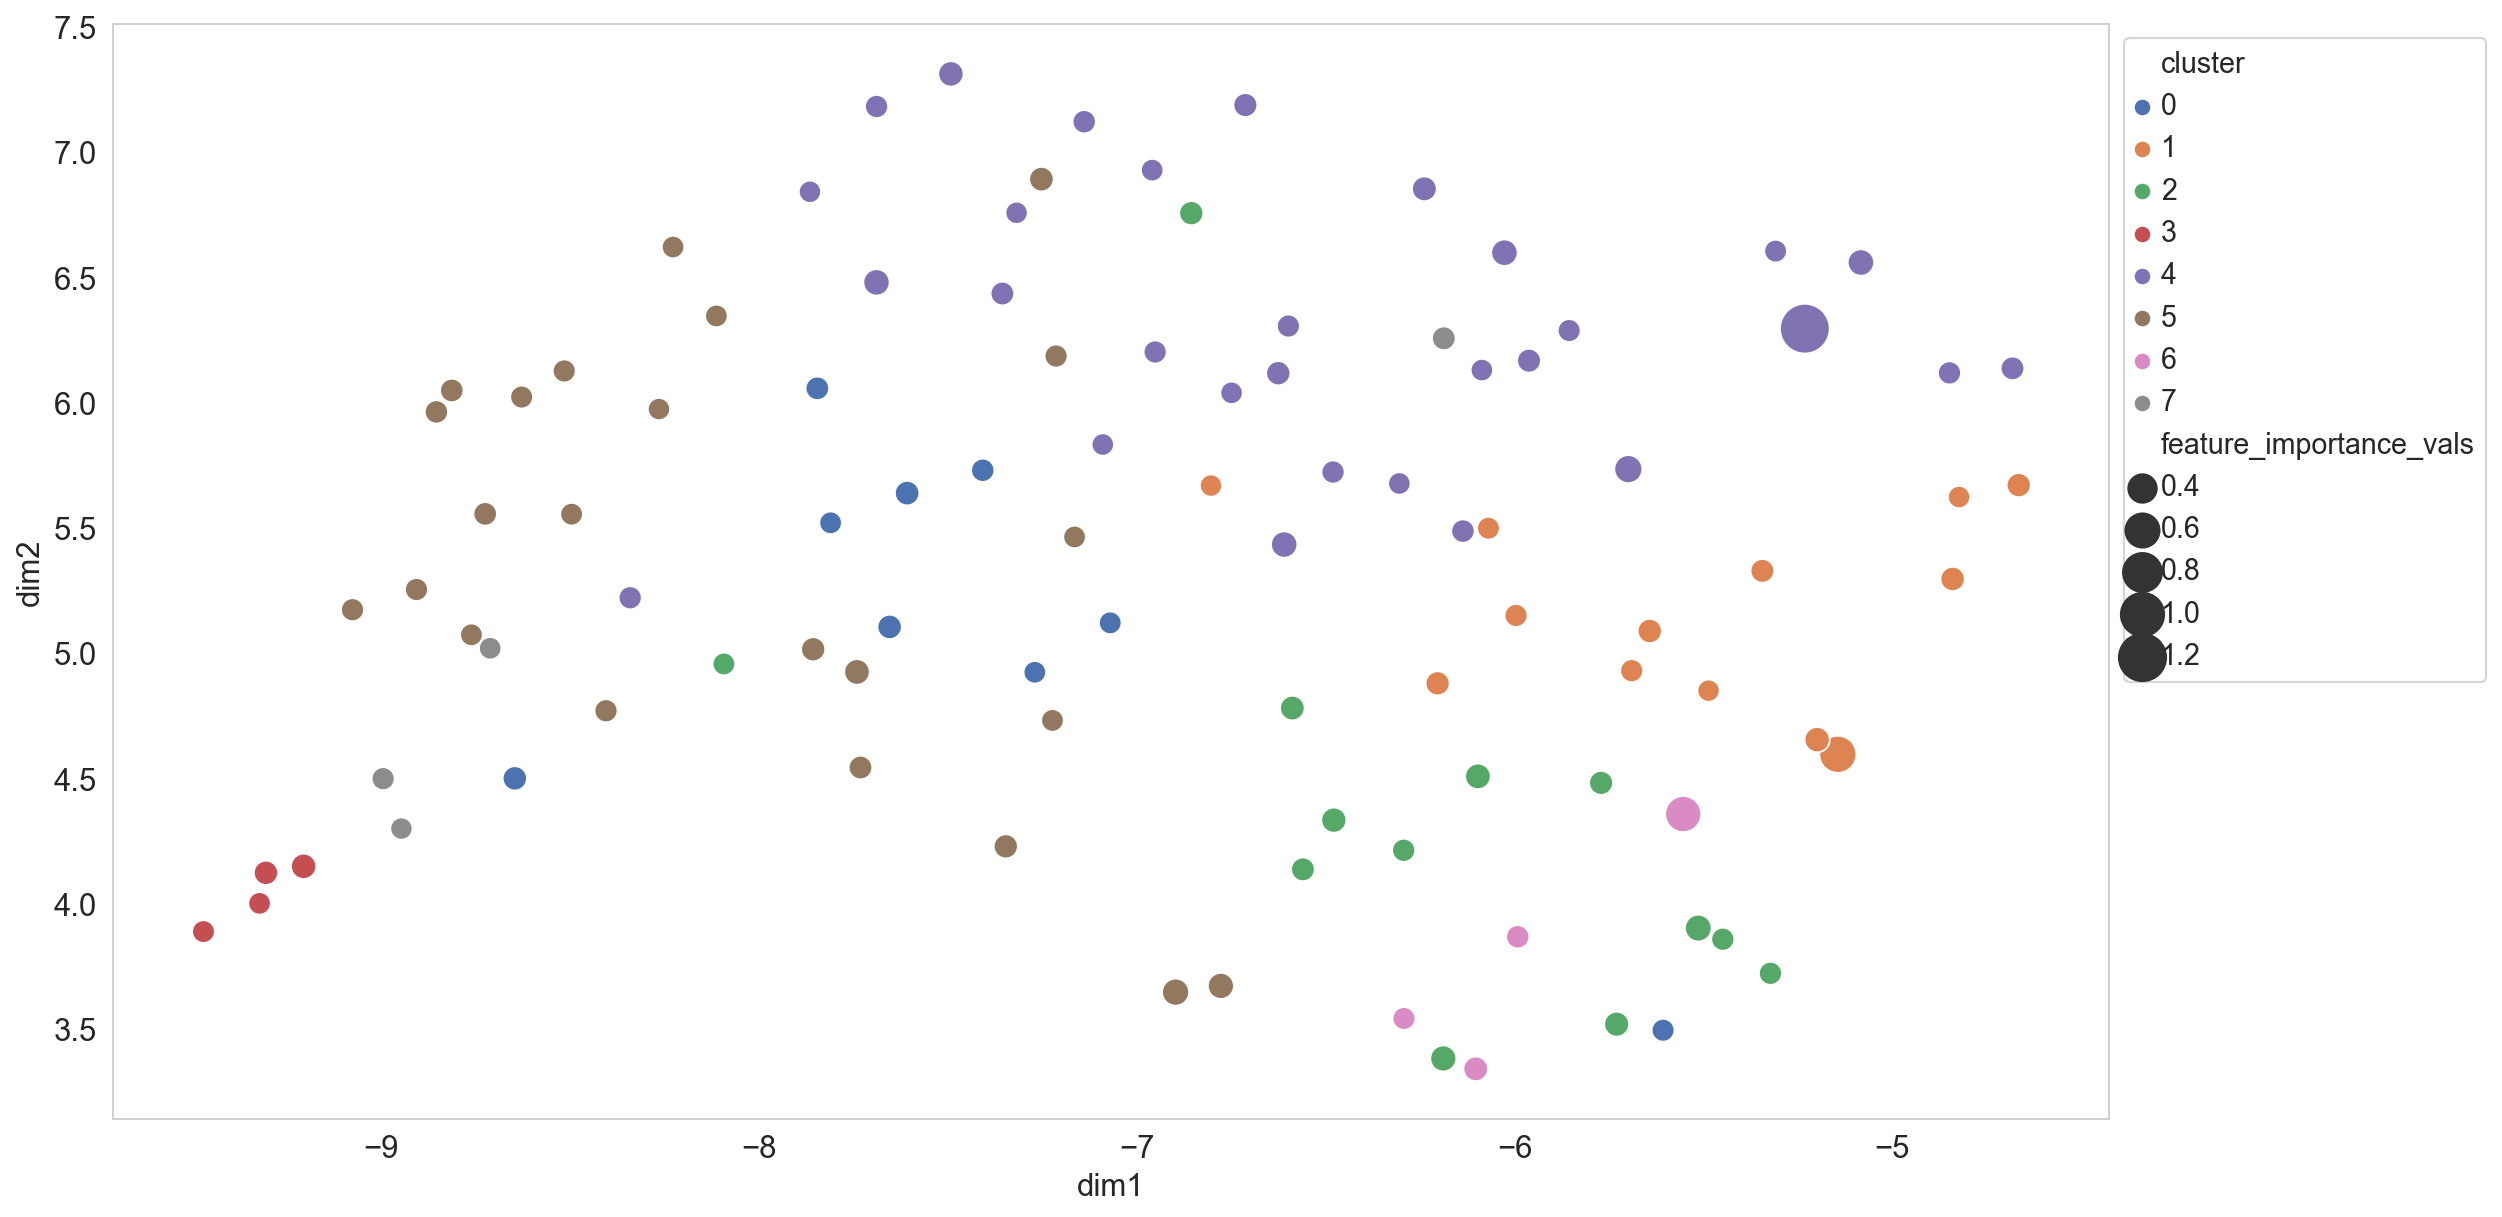

In [26]:
# Create a scatter plot of the principal components, colored by the "cluster" column
plt.figure(figsize=(16,9))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.scatterplot(data=clusters_df, x='dim1', y='dim2',
                     sizes=(100, 500),
                     palette='deep',
                      hue='cluster',
                        size='feature_importance_vals')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))